In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

2025-04-30 16:40:15.441411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746031215.653833      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746031215.712427      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATASET_PATH = "/kaggle/input/lung-cancer-histopathological-images"
WORKING_DIR = "/kaggle/working/dataset"
if not os.path.exists(WORKING_DIR):
    shutil.copytree(DATASET_PATH, WORKING_DIR)

In [3]:
classes = ["adenocarcinoma", "benign", "squamous_cell_carcinoma"]

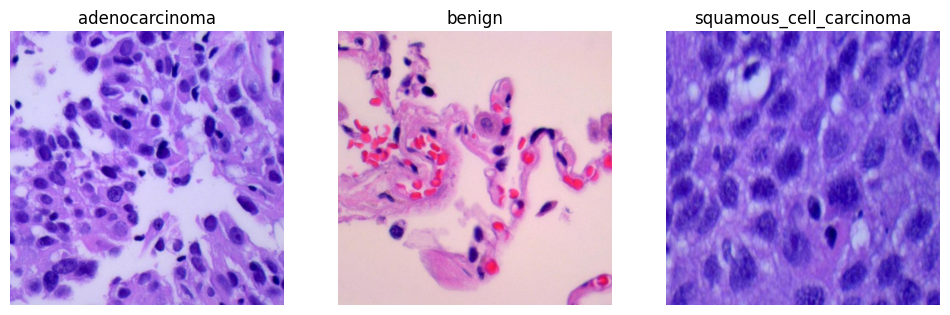

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(classes):
    img_path = os.path.join(WORKING_DIR, label)
    img_file = random.choice(os.listdir(img_path))
    img = cv2.imread(os.path.join(img_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# Create ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    fill_mode='nearest'
)
# trying squeezenet with basically no augumentation to get a clearer picture
# Load training data
train_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def fire_module(x, squeeze_filters, expand_filters):
    x = layers.Conv2D(squeeze_filters, (1, 1), activation='relu')(x)
    left = layers.Conv2D(expand_filters, (1, 1), activation='relu')(x)
    right = layers.Conv2D(expand_filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.concatenate([left, right])
    return x

def build_squeezenet(input_shape=(224, 224, 3), num_classes=3):
    input_img = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(96, (7, 7), strides=(2, 2), padding='valid', activation='relu')(input_img)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 64, 256)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(num_classes, (1, 1), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Activation('softmax')(x)

    model = models.Model(inputs=input_img, outputs=output)
    return model

# Build SqueezeNet
model = build_squeezenet()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 109, 109, 96)   │         14,208 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 54, 54, 96)     │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 54, 54, 16)     │          1,552 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 54, 54, 64)     │          1,088 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 54, 54, 64)     │          9,280 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 54, 54, 128)    │              0 │ conv2d_28[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 54, 54, 16)     │          2,064 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 54, 54, 64)     │          1,088 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 54, 54, 64)     │          9,280 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 54, 54, 128)    │              0 │ conv2d_31[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 54, 54, 32)     │          4,128 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 54, 54, 128)    │          4,224 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 54, 54, 128)    │         36,992 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 54, 54, 256)    │              0 │ conv2d_34[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 26, 26, 256)    │              0 │ concatenate_10[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)   

 Total params: 736,963 (2.81 MB)

 Trainable params: 736,963 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  
    patience=3,  
    min_lr=1e-6
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 100s 437ms/step - accuracy: 0.5577 - loss: 0.9121 - val_accuracy: 0.7913 - val_loss: 0.4449 - learning_rate: 1.0000e-04
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - accuracy: 0.7975 - loss: 0.4393 - val_accuracy: 0.8780 - val_loss: 0.3242 - learning_rate: 1.0000e-04
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.8646 - loss: 0.3289 - val_accuracy: 0.9023 - val_loss: 0.2662 - learning_rate: 1.0000e-04
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 346ms/step - accuracy: 0.8886 - loss: 0.2773 - val_accuracy: 0.8430 - val_loss: 0.3603 - learning_rate: 1.0000e-04
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.8985 - loss: 0.2521 - val_accuracy: 0.9153 - val_loss: 0.2257 - learning_rate: 1.0000e-04
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 347ms/step - accuracy: 0.9121 - loss: 0.2148 - val_accuracy: 0.9277 - val_loss: 0.1796 - learning_rate: 1.0000e-04
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 3

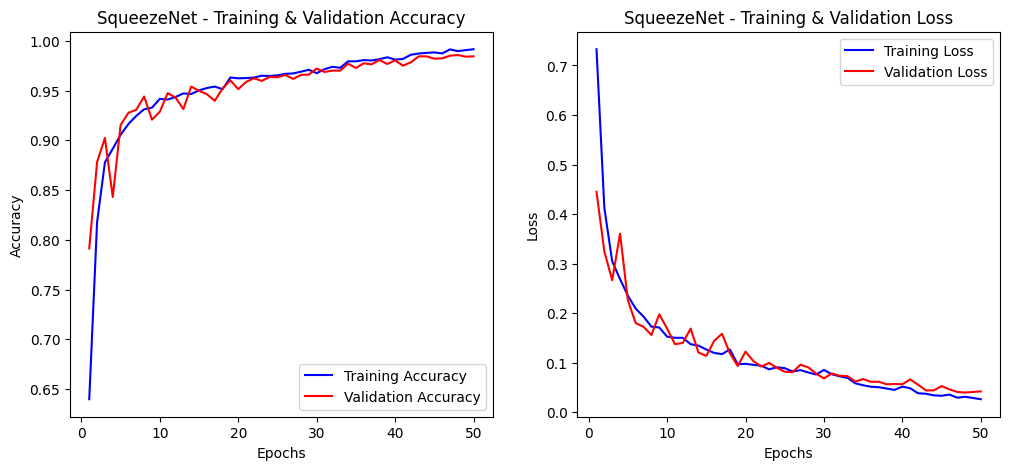

SqueezeNet model saved.


In [11]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SqueezeNet - Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SqueezeNet - Training & Validation Loss')
plt.legend()

plt.show()

# Save model
model.save('/kaggle/working/squeezenet_lung_cancer_unaugumented.h5')
print("SqueezeNet model saved.")

In [13]:
import tensorflow as tf
import os

# Load the trained .h5 model
model = tf.keras.models.load_model('/kaggle/working/squeezenet_lung_cancer_unaugumented.h5')
print("Model loaded successfully.")

# Convert to TFLite with float16 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # Enable float16 quantization

tflite_model = converter.convert()

# Save the TFLite model
tflite_path = "/kaggle/working/squeezenet_lung_cancer_unaugumented_float16.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f"Model converted and saved to {tflite_path}")

Model loaded successfully.
Saved artifact at '/tmp/tmpfv7wi83e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132712865103120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132708531732112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132708531730576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132708531730768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132708531730192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132708531729616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132708531729424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132708531728848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132708531728656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132708531728080: TensorSpec(shape=(), dtype=tf.resource,

W0000 00:00:1746035182.099437      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746035182.099468      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [14]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np

# Define constants
WORKING_DIR = '/kaggle/working/dataset' # Or wherever your training data is
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CALIBRATION_STEPS = 100 # Adjust as needed

# Load the trained .h5 model
model = tf.keras.models.load_model('/kaggle/working/squeezenet_lung_cancer_unaugumented.h5')
print("Model loaded successfully.")

# Function to provide representative data for quantization
def representative_data_gen():
    # Use the same ImageDataGenerator for preprocessing
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Keep same preprocessing as training

    # Flow data from the directory, but this time only get the training split
    calibration_data = datagen.flow_from_directory(
        WORKING_DIR,
        target_size=IMG_SIZE,
        batch_size=1,  # Important: Batch size must be 1 for calibration
        class_mode='categorical',
        subset='training',
        shuffle=False # Important: Keep the order the same
    )

    # Loop through the dataset and yield batches of size 1.
    for i in range(NUM_CALIBRATION_STEPS):
        # Get the next batch.  `x` is the image data.
        x, _ = calibration_data[i] # Only need the image data, not the labels
        yield [x]  # Yield a list containing the single image.



# Convert to TFLite with INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable quantization
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

# Save the TFLite model
tflite_path_quant = "squeezenet_lung_cancer_unaugumented_int8.tflite" # changed the save path
with open(tflite_path_quant, "wb") as f:
    f.write(tflite_model_quant)

print(f"Quantized model converted and saved to {tflite_path_quant}")


Model loaded successfully.
Saved artifact at '/tmp/tmp4vmdabln'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132710875105808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132710875104272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132712011646352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132712011649232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132712011648272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132712011649808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132712011650960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132712011647504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132712011651152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132712011652496: TensorSpec(shape=(), dtype=tf.resource,

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1746035200.464029      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746035200.464058      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Found 12000 images belonging to 3 classes.
Quantized model converted and saved to squeezenet_lung_cancer_unaugumented_int8.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
